[Google Colaboratory](http://colab.research.google.com) is designed to integrate cleanly with GitHub, allowing both loading notebooks from github and saving notebooks to github.

# **Pycaret**によるAutoML体験
～専門知識はほぼ不要。数行でできる機械学習体験～

### Pycaretとは

PyCaretとは、機械学習のモデル開発においてデータ前処理や可視化、モデル開発を数行のコードで出来てしまうPythonのライブラリです。

PyCaretはいくつかの主要な機械学習ライブラリ（scikit-learn, XGBoost, LightGBMなど）をPythonでラッパーしたもので、分類や回帰、クラスタリング、異常検知、自然言語処理が扱えます。

<b>※リファレンス： https://pycaret.org/guide/


### **Pycaretで東京電力の電力需要を予測する**

今回使った学習データの所在

*   東京電力「過去の電力使用実績のダウンロード」[ここから入手](http://www.tepco.co.jp/forecast/html/download-j.html)
*   気象庁「過去の気象データ・ダウンロード」[ここから入手](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)


## **準備**

今回使うサンプルデータ(予め用意してある東京電力＆気象庁のCSV)をColab環境にダウンロードする。※wgetでGitHubからダウンロード※

In [ ]:
!wget https://raw.githubusercontent.com/gh-yana/testing1/master/notebook/data/TokyoPower_weather_2017-2018_Train_NoDefects.csv /content -q
!wget https://raw.githubusercontent.com/gh-yana/testing1/master/notebook/data/TokyoPower_weather_2017-2018_Train_Defects.csv /content -q
!wget https://raw.githubusercontent.com/gh-yana/testing1/master/notebook/data/weather_20190401_05_Pred-in.csv /content -q
!wget https://raw.githubusercontent.com/gh-yana/testing1/master/notebook/data/TokyoPower_Real_20190401_05.csv /content -q
!wget https://raw.githubusercontent.com/gh-yana/testing1/master/notebook/data/lr-Pred_kw.csv /content -q
!ls -l /content

total 1200
drwx------ 5 root root   4096 Nov 14 07:43 drive
-rw-r--r-- 1 root root   1299 Nov 14 08:22 lr-Pred_kw.csv
drwxr-xr-x 1 root root   4096 Nov  6 17:30 sample_data
-rw-r--r-- 1 root root   2114 Nov 14 08:22 TokyoPower_Real_20190401_05.csv
-rw-r--r-- 1 root root 618570 Nov 14 08:22 TokyoPower_weather_2017-2018_Train_Defects.csv
-rw-r--r-- 1 root root 583152 Nov 14 08:22 TokyoPower_weather_2017-2018_Train_NoDefects.csv
-rw-r--r-- 1 root root   3140 Nov 14 08:22 weather_20190401_05_Pred-in.csv


Pycaretをインストールする。（だいたい1分くらいかかった）


In [ ]:
!pip install pycaret

     |████████████████████████████████| 256kB 14.6MB/s 
     |████████████████████████████████| 66.2MB 65kB/s 
     |████████████████████████████████| 6.8MB 46.2MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 266kB 55.9MB/s 
     |████████████████████████████████| 174kB 46.3MB/s 
     |████████████████████████████████| 1.6MB 51.0MB/s 
     |████████████████████████████████| 13.9MB 240kB/s 
     |████████████████████████████████| 148.9MB 90kB/s 
     |████████████████████████████████| 1.8MB 43.3MB/s 
     |████████████████████████████████| 276kB 38.0MB/s 
     |████████████████████████████████| 2.1MB 44.1MB/s 
     |████████████████████████████████| 604kB 51.3MB/s 
     |████████████████████████████████| 3.1MB 40.0MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 1.1MB 47.9MB/s 
     |████████████████████████████████| 81kB 11.4MB

In [ ]:
import pycaret
print(pycaret.__version__)   # インストールされたバージョンを確認 (2020年11月時点は2.2.0だった。必要に応じてV/L指定でインスコ)

2.2.0


学習データとして使うCSVをPandasのデータフレームに読み込む。今回は、東電の電力データと気象庁データを事前にマージしてあるので、それを使う。<br>
*   Train_NoDefects.csv：欠損値なし（事前に手作業でレコード除去）
*   Train_Defects.csv：<font color=red>欠損値<b>あり</b></font>（今回、4731行目あたりに存在）

※以前scikit-learnで回帰モデル作成した際、欠損データがあったのでモデル作成できなかったことがあり・・・当時は手作業のレコード削除で逃げた。。(-_-;)欠損ってかなり曲者。

In [ ]:
import pandas as pd
#train_data = pd.read_csv("/content/TokyoPower_weather_2017-2018_Train_NoDefects.csv")
train_data = pd.read_csv("/content/TokyoPower_weather_2017-2018_Train_Defects.csv")
train_data.head()

,DATE,TIME_hh,TIME_mm,Man_kW,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,2017/1/1,1,0,2634,5.1,0.0,3.5,0.0
1,2017/1/1,2,0,2520,4.1,0.0,1.7,0.0
2,2017/1/1,3,0,2438,4.0,0.0,1.5,0.0
3,2017/1/1,4,0,2389,3.0,0.0,1.0,0.0
4,2017/1/1,5,0,2394,3.6,0.0,2.2,0.0


【参考】欠損値の確認（sample_new3を読み込んだ場合）<br>
<font color=red>日照時間(Sun_h)と風速(Wind_p_par_S)データの一部に欠損(NaN:Not a Number)あり</font>

In [ ]:
#train_data[4585:4595]
train_data[4730:4740]

,DATE,TIME_hh,TIME_mm,Man_kW,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
4730,2017/7/17,3,0,2620,28.1,0.0,3.5,0.0
4731,2017/7/17,4,0,2612,27.2,NaN,NaN,0.0
4732,2017/7/17,5,0,2629,27.4,NaN,NaN,0.0
4733,2017/7/17,6,0,2751,27.7,NaN,NaN,0.0
4734,2017/7/17,7,0,3047,27.0,NaN,NaN,0.0
4735,2017/7/17,8,0,3482,26.1,NaN,NaN,0.0
4736,2017/7/17,9,0,3913,28.8,0.0,1.6,0.0
4737,2017/7/17,10,0,4157,31.1,0.3,1.4,0.0
4738,2017/7/17,11,0,4338,32.8,1.0,2.4,0.0
4739,2017/7/17,12,0,4354,33.5,0.9,2.1,0.0


## **Pycaretの前処理**

Pycaretでデータ前処理を実行。<br>
<BR>
*   第１引数：解析データ(必須)
*   第２引数：目的変数(必須)
*   第３引数：サイレントモード
*   第４引数：欠損値補完（mean:平均値、median:中央値）

<br><b>
※欠損値の有無（4行目のMissing Values）<br>
※欠損値補完モード（22行目のNumeric Imputer）
</b><br>その他はリファレンス参照。。。

In [ ]:
from pycaret.regression import *  #回帰
exp_clf101 = setup(data = train_data, target = "Man_kW" , silent = True , numeric_imputation = 'mean')

,Description,Value
0,session_id,6745
1,Target,Man_kW
2,Original Data,"(17519, 8)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(12263, 27)"


## **<font color=red>【ポイント！】</font>自動比較して最適モデルを見つける**


ライブラリ内のすべてのモデルでトレーニングし、モデルを比較する。今回は回帰モデル。（だいたい2分くらいかかかった）<br>
回帰の場合、R2の順で表示される。<br>
※R2(R二乗)：決定係数。予測が実際の値に比べてどのくらい当たっているかを客観的に表す指数。詳細は統計をおさらいして。。。

In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,95.9018,20670.1755,143.5257,0.9527,0.0423,0.0289,2.749
xgboost,Extreme Gradient Boosting,100.1449,22671.8100,150.3145,0.9481,0.0442,0.0302,1.721
lightgbm,Light Gradient Boosting Machine,105.2224,24223.9842,155.4707,0.9446,0.0459,0.0318,0.146
et,Extra Trees Regressor,102.2131,24376.1789,155.9754,0.9442,0.0458,0.0307,3.255
rf,Random Forest Regressor,109.8486,27744.5944,166.3676,0.9365,0.0488,0.0330,3.700
gbr,Gradient Boosting Regressor,130.2459,34659.8923,186.0091,0.9207,0.0548,0.0393,0.804
knn,K Neighbors Regressor,147.9329,43521.9312,208.5384,0.9004,0.0611,0.0446,0.129
dt,Decision Tree Regressor,146.6852,52981.8508,229.9601,0.8788,0.0675,0.0438,0.082
ada,AdaBoost Regressor,269.2569,106684.8687,326.4226,0.7562,0.1014,0.0855,0.620
br,Bayesian Ridge,343.2622,190297.2795,436.1356,0.5648,0.1282,0.1047,0.034


↑↑↑↑↑↑↑↑↑↑↑↑<BR>
CatBoost Regressorというモデルが選択された。CatBoostは、決定木の勾配ブースティングのアルゴリズムで、Yandexの研究者およびエンジニアによって開発され・・・らしいが、ここではどうでもよく、R2のスコアが最もよかったモデルが自動で分かる点がGood。


In [ ]:
#精度に基づいて上位3モデルを返す（おまけ）
compare_models(n_select=3)

比較結果を基に、モデルを作成する。<br>
（比較評価で一番最適なものを選ぶ。今回は、catboost）

In [ ]:
model = create_model("catboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,100.2829,23483.2131,153.2423,0.9463,0.0444,0.0299
1,90.4732,16376.8593,127.9721,0.9631,0.0386,0.0276
2,98.2466,21551.1393,146.8031,0.9477,0.0433,0.0298
3,96.9575,19476.0654,139.5567,0.9601,0.0416,0.0294
4,96.7448,23596.2992,153.6109,0.9475,0.0454,0.0295
5,94.1818,18610.9746,136.4220,0.9570,0.0399,0.0282
6,91.4751,18222.3684,134.9903,0.9579,0.0392,0.0274
7,100.9646,23326.5652,152.7304,0.9470,0.0443,0.0300
8,94.5011,19927.5990,141.1651,0.9528,0.0420,0.0286
9,95.1899,22130.6710,148.7638,0.9474,0.0442,0.0290


（参考）解析結果を可視化<br>

*   Hyperparameters：ハーパーパラメータの確認
*   Residuais：残差分析の確認（外れ値の確認）
*   Prediction Error：予測精度の確認

などなど。詳細はリファレンス参照。



In [ ]:
evaluate_model(model)

## 推論

**モデルをファイナライズし、推論を行う。**<br>
モデルのファイナライズする。その後、未知のデータ<font color=red>(<b>説明変数</B>のみのCSVをPandasデータフレームに<b>読み込む</b>)</font>を使って推論<font color=red>(<b>目的変数</b>Man_kWの値を<b>Predict</b>する)</font>を行う。<br>（Xを読み込んで予測し、Yを導出するみたいなもん。だいたい1分くらいかかった）

In [ ]:
final_model = finalize_model(model)
data_unseen = pd.read_csv("/content/weather_20190401_05_Pred-in.csv")
result = predict_model(final_model, data = data_unseen)

推論結果の確認（とりあえず、先頭20行を表示）。<br>
右のLabelが、推論した目的変数(電力需要 Man_kW の値）。

In [ ]:
result.head(20)

,DATE,TIME_hh,TIME_mm,Temp_C,Sun_h,Wind_m_par_S,Rain_mm,Label
0,2019/4/1,1,0,8.2,0.0,3.3,0.0,2381.994191
1,2019/4/1,2,0,7.8,0.0,4.1,0.0,2412.437784
2,2019/4/1,3,0,7.3,0.0,2.4,0.0,2409.525008
3,2019/4/1,4,0,7.1,0.0,4.1,0.0,2440.757743
4,2019/4/1,5,0,6.7,0.0,1.8,0.0,2489.838512
5,2019/4/1,6,0,6.6,0.3,3.4,0.0,2759.847679
6,2019/4/1,7,0,8.0,1.0,2.3,0.0,2862.200929
7,2019/4/1,8,0,8.7,0.7,4.7,0.0,3166.850822
8,2019/4/1,9,0,11.0,0.8,2.4,0.0,3294.800184
9,2019/4/1,10,0,13.2,1.0,2.2,0.0,3132.322767


**ちゃんと推論できました。**



---



【おまけ】<br>
とりあえず、どの程度あってるかを確認。


電力実績データを読み込み、予測データをカラム追加する。

In [ ]:
real_kw_df = pd.read_csv("/content/TokyoPower_Real_20190401_05.csv")   # 2019/4/1-4/5の実測値（予測値との比較用）
real_kw_df = real_kw_df.drop("DATE",axis=1)  # 不要カラム削除
real_kw_df = real_kw_df.drop("TIME_hh",axis=1)  # 不要カラム削除
#real_kw_df.head()
comp_df = pd.concat([result, real_kw_df], axis=1)    # 予測結果に実績カラムを追加
comp_df = comp_df.rename(columns={"Label" : "catboost-Pred_Man_kW"})   # 予測結果のカラム名(Label)を変更
comp_df.head()

,DATE,TIME_hh,TIME_mm,Temp_C,Sun_h,Wind_m_par_S,Rain_mm,catboost-Pred_Man_kW,Man_kW
0,2019/4/1,1,0,8.2,0.0,3.3,0.0,2381.994191,2493
1,2019/4/1,2,0,7.8,0.0,4.1,0.0,2412.437784,2480
2,2019/4/1,3,0,7.3,0.0,2.4,0.0,2409.525008,2493
3,2019/4/1,4,0,7.1,0.0,4.1,0.0,2440.757743,2547
4,2019/4/1,5,0,6.7,0.0,1.8,0.0,2489.838512,2712


グラフで見てみる

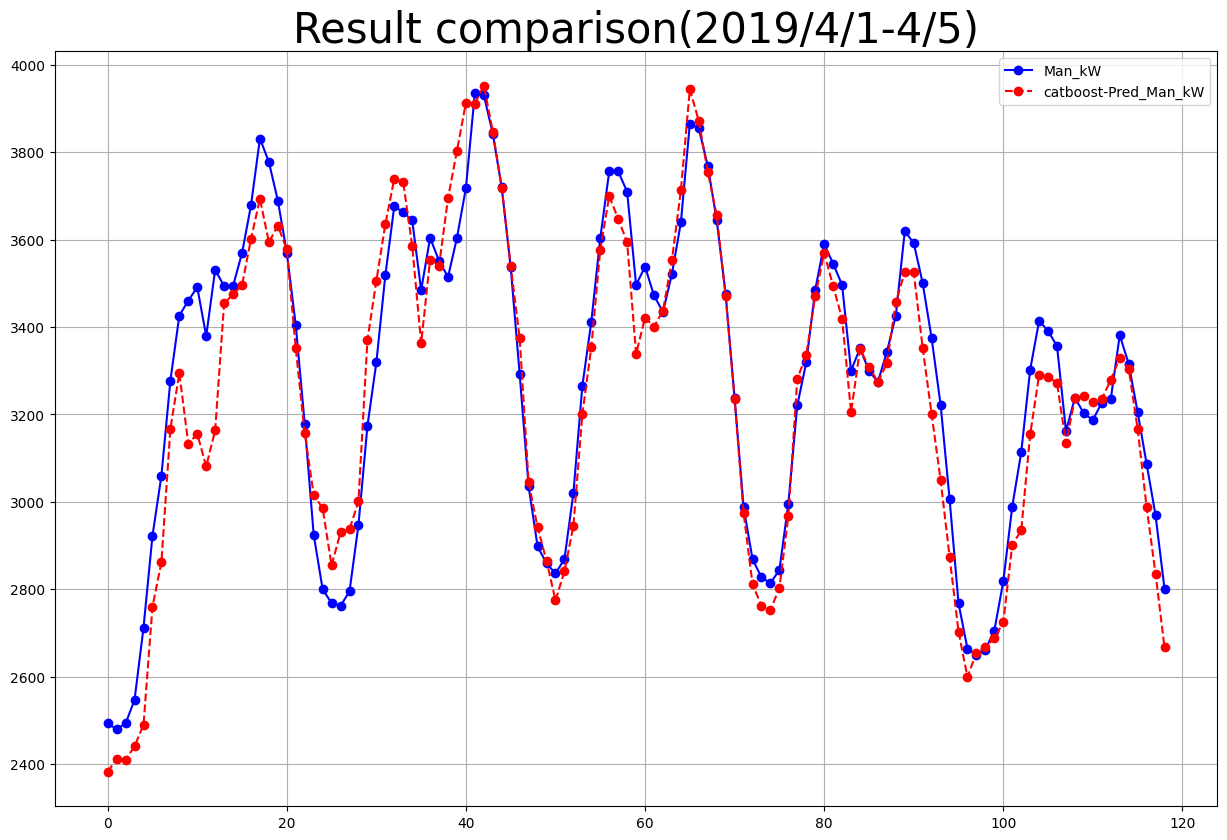

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array(range(119))  # X用に119個までの連番生成（とりあえず表示するだけなので）
plt.figure(figsize=(15, 10),dpi=100)
plt.title("Result comparison(2019/4/1-4/5)", size=30)
plt.grid(True)
plt.plot(x,comp_df["Man_kW"],color="b",marker="o",label="Man_kW")
plt.plot(x,comp_df["catboost-Pred_Man_kW"],color="r",marker="o",linestyle="--",label="catboost-Pred_Man_kW")
plt.legend()

【参考】Linear Regressionの結果と比べてみる

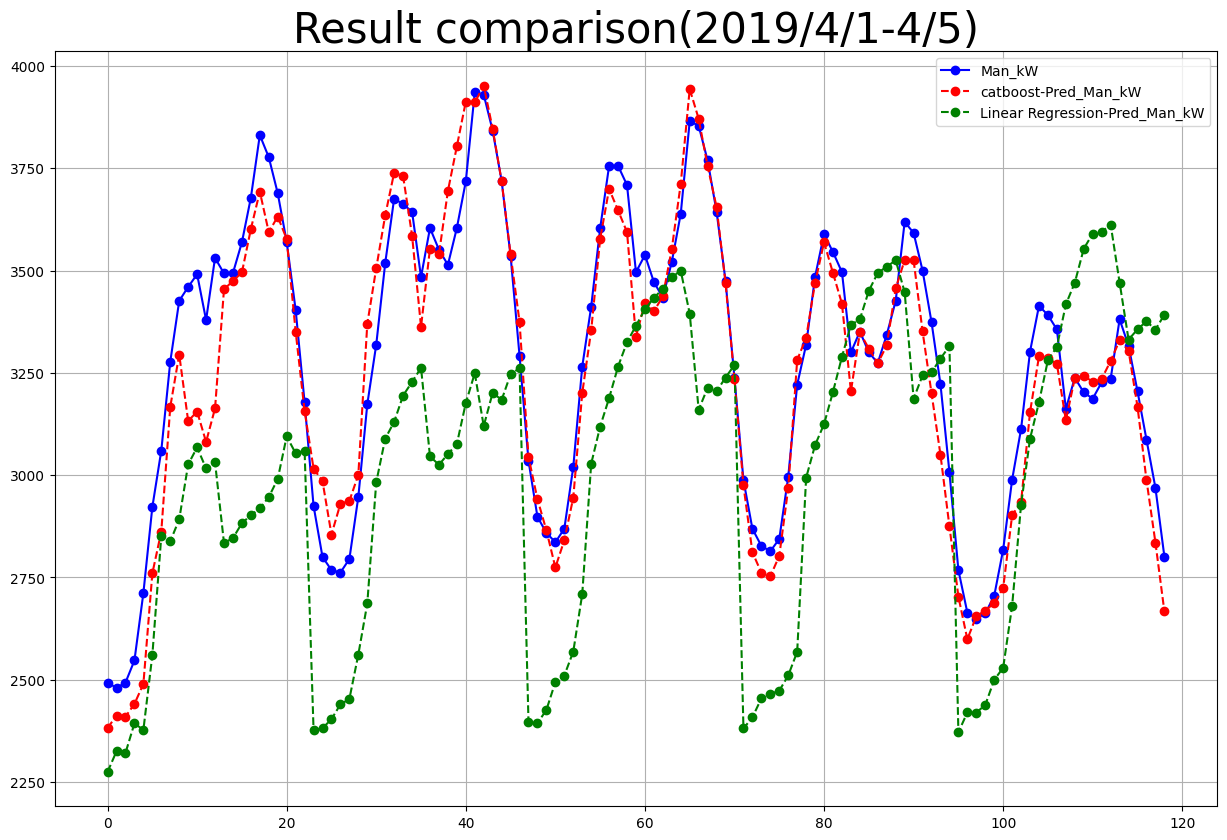

In [ ]:
lr_kw_df = pd.read_csv("/content/lr-Pred_kw.csv")   # 比較用として事前にLinear Regressionモデルで推論した電力値を読み込む
dmy_df = pd.concat([comp_df, lr_kw_df], axis=1)    # カラムを追加
#dmy_df.head()
plt.figure(figsize=(15, 10),dpi=100)
plt.title("Result comparison(2019/4/1-4/5)", size=30)
plt.grid(True)
plt.plot(x,dmy_df["Man_kW"],color="b",marker="o",label="Man_kW")
plt.plot(x,dmy_df["catboost-Pred_Man_kW"],color="r",marker="o",linestyle="--",label="catboost-Pred_Man_kW")
plt.plot(x,dmy_df["lr-Pred_Man_kW"],color="g",marker="o",linestyle="--",label="Linear Regression-Pred_Man_kW")
plt.legend()




---



## おわり

詳細はこちら


https://pycaret.org/